In [ ]:
from IPython.display import clear_output
!pip install tensorflow==2.7.0
clear_output()

In [ ]:
from IPython.display import clear_output
!pip install tensorflow-quantum==0.6.0 --use-deprecated=legacy-resolver
clear_output()

In [ ]:
from IPython.display import clear_output
!pip install pennylane
clear_output()

In [ ]:
import numpy as np 
import sympy as sp
import pandas as pd
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import pennylane as qml
from cirq.contrib.svg import SVGCircuit
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from numpy import asarray
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

from h5py import File as HDF5File
%matplotlib inline
import matplotlib.pyplot as plt

import keras.backend as K
# tf.config.run_functions_eagerly(True)

In [ ]:
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
# print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

In [ ]:
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
electron_datafile = '/content/gdrive/MyDrive//electron.hdf5'
photon_datafile = '/content/gdrive/MyDrive//photon.hdf5'

In [ ]:
electron_data = HDF5File(electron_datafile, 'r')
photon_data = HDF5File(photon_datafile, 'r')

In [ ]:
print(electron_data.keys())

<KeysViewHDF5 ['X', 'y']>


In [ ]:
X_e, y_e = electron_data['X'], electron_data['y']
X_e_0 = X_e[:,:,:,0]
X_e_1 = X_e[:,:,:,1]
print(X_e_0.shape)
print(y_e.shape)

(249000, 32, 32)
(249000,)


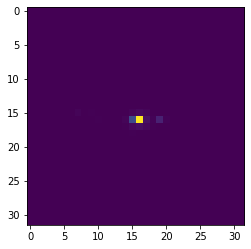

In [ ]:
plt.imshow(X_e_0[0,:,:])

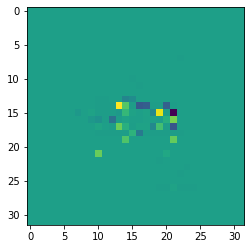

In [ ]:
plt.imshow(X_e_1[0,:,:])

In [ ]:
X_p, y_p = photon_data['X'], photon_data['y']
X_p_0 = X_p[:,:,:,0]
X_p_1 = X_p[:,:,:,1]
print(X_p_0.shape)
print(y_p.shape)

(249000, 32, 32)
(249000,)


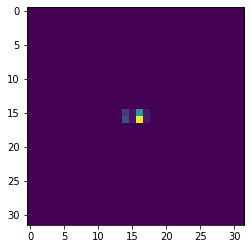

In [ ]:
plt.imshow(X_p_0[0,:,:])

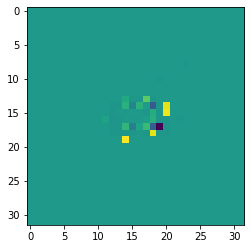

In [ ]:
plt.imshow(X_p_1[0,:,:])

In [ ]:
import operator

def crop_images(image,dimension):
  start = tuple(map(lambda a, da: a//2-da//2, image.shape, dimension))
  end = tuple(map(operator.add, start, dimension))
  slices = tuple(map(slice, start, end))
  return image[slices]
      

In [ ]:
center = [int(528/32), 528%32]

img_size = 8
X_e_0 = X_e_0[:100, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
X_p_0 = X_p_0[:100, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]

print(X_e_0.shape,X_p_0.shape)
# slices = crop_images(X_e[25000,:,:,0],(16,16))
# plt.imshow(crop_images(X_e[25000,:,:,0],(16,16)))

(100, 8, 8) (100, 8, 8)


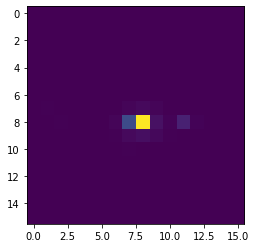

In [ ]:
plt.imshow(X_e_0[0])

In [ ]:
from sklearn.decomposition import PCA

X_flatten = X_e_0.reshape(-1,X_e_0.shape[1]*X_e_0.shape[2])
pca = PCA(n_components=4)
pca.fit(X_flatten)
X_pca_transform = pca.transform(X_flatten)
print(X_pca_transform.shape)
# X_pca_transform[1].reshape((20,20))
print(np.cumsum(pca.explained_variance_ratio_))

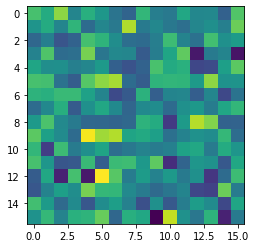

In [ ]:
z_shape = (16,16)
z = tf.random.normal(z_shape)
z = z.numpy()
plt.imshow(z)

In [ ]:
def one_proj(a):
    return 0.5 * (1 - cirq.Z(a))

In [ ]:
l = 5
print(l)
print(bin(l))
m = 5 << 2
print(m)
print(bin(m))

5
0b101
20
0b10100


In [ ]:
qubit1 = cirq.GridQubit(1,1)
qubit2 = cirq.GridQubit(1,1)
k = one_proj(qubit1) * one_proj(qubit2)
print(one_proj(qubit1))
print(k)

-0.500*Z(q(1, 1))+0.500*I
0.500*I-0.500*Z(q(1, 1))


In [ ]:
z_shape = (5,5)
z = tf.random.normal(z_shape)
print(z.numpy())

[[-1.0119802e-03  1.9063383e-01 -1.6093738e+00 -1.0551535e+00
   4.9614340e-01]
 [ 7.8770453e-01 -4.6049950e-01 -3.8391042e-01  1.6465148e-01
  -1.4932785e+00]
 [-1.1492304e+00 -2.0368380e-02  9.2384130e-01 -6.1044919e-01
  -1.3990656e-01]
 [ 2.0169294e+00  5.4266024e-01 -1.6061226e+00 -1.8086742e+00
   1.2880011e+00]
 [-1.4543334e+00  1.3902817e+00 -1.2583441e+00  5.3861130e-02
  -1.7481257e+00]]


# Circuits

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def one_qubit_unitary(qubit, symbols):
  return cirq.Circuit(
    [cirq.rz(symbols[0])(qubit),
      cirq.ry(symbols[1])(qubit),
      cirq.rz(symbols[2])(qubit)]
  )

In [ ]:
def two_qubit_unitary(qubits):
  cx_ops = [cirq.CX(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
  cx_ops += ([cirq.CX(qubits[-1], qubits[0])] if len(qubits) != 2 else [])
  return cx_ops

In [ ]:
def pqc_circuit_for_conv(qubits,layers):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  input_symbols = sp.symbols('x_:'+str(num_qubits))
  param_symbols = sp.symbols('theta_:'+str(3*num_qubits*layers))
  param_symbols = np.reshape(param_symbols,(layers,num_qubits,3))
  for i in range(num_qubits):
    circuit += cirq.ry(input_symbols[i])(qubits[i])
  
  for layer in range(layers):
    for i,q in enumerate(qubits):
      circuit += one_qubit_unitary(q,param_symbols[layer,i,:])
    circuit += two_qubit_unitary(qubits)
  
  return circuit,input_symbols,list(param_symbols.flat)

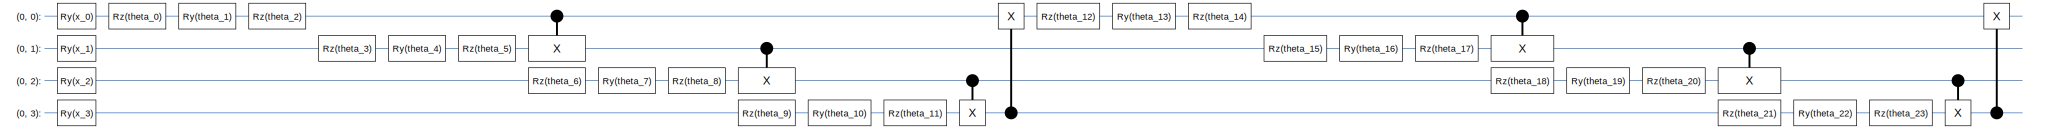

In [ ]:
demo_circuit,i_symbols,p_symbols = pqc_circuit_for_conv(cirq.GridQubit.rect(1,4),layers=2)
SVGCircuit(demo_circuit)
# print(p_symbols)

In [ ]:
class QConvPQC(tf.keras.layers.Layer):
   def __init__(self,n_qubits,layers,name='Quantum Convolutional layer'):
     super(QConvPQC,self).__init__(name=name)
     self.num_qubits = n_qubits
    #  self.symbols = symbols
     self.layers = layers
     self.main_name = name
     self.qubits = cirq.GridQubit.rect(1, n_qubits)
     self.observables = cirq.Z(self.qubits[-1])
     circuit, input_symbols, param_symbols = pqc_circuit_for_conv(cirq.GridQubit.rect(1,self.num_qubits),layers=self.layers)
     param_vals = tf.random_uniform_initializer(minval=-np.pi,maxval=np.pi)
     self.params = tf.Variable(
         initial_value=param_vals(shape=(1,len(param_symbols)),dtype='float32'),
         trainable = True,
         name = self.name + '-parameters'
     ) 
     self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])

     self.computation_layer = tfq.layers.ControlledPQC(circuit, self.observables)
    
   def get_config(self):
     config = super().get_config().copy()
     config.update({
         'qubit_count':self.num_qubits,
        #  'symbols':self.symbols,
         'layer_count':self.layers,
         'layer_name':self.name
     })
     return config
   def call(self,inputs):
     batch_size = tf.shape(inputs)[0]
     
     inputs_flattened = tf.keras.layers.Flatten()(inputs)
     quantum_inputs = tf.math.atan(inputs_flattened)
     params_batch = tf.tile(self.params, multiples=[batch_size,1], name=self.name + '-tiled_up_parameters')
     empty_circuits_batch = tf.repeat(self.empty_circuit, repeats = batch_size, name=self.name + '-empty_circuits')
     
     joined_params = tf.concat([quantum_inputs,params_batch],axis=-1)

     return self.computation_layer([empty_circuits_batch,joined_params])

In [ ]:
def QConv_layer(inputs,layers,filter_size,stride,conv_id='',name='QConv_layer_'):
  iter = int(1 + (inputs.shape[1]-filter_size)/stride)
  n_qubits = filter_size*filter_size
  pqc = QConvPQC(n_qubits=n_qubits,layers=layers,name=name+conv_id) # 
  conv = []
  for i in range(iter):
    for j in range(iter):
      temp = pqc(inputs[:,stride*i:filter_size+i*stride,stride*i:filter_size+i*stride])
      conv += [temp]
  output_concat = tf.keras.layers.Concatenate(axis=1)(conv)
  output_reshape = tf.keras.layers.Reshape((iter,iter),name='Reshape_'+conv_id)(output_concat)
  return output_reshape

In [ ]:
layers = 2
filter_size = [4,3,2]
stride = [1,1,1]

data_inputs = tf.keras.Input(shape=(X_e_0.shape[1], X_e_0.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer')
conv_1 = QConv_layer(inputs=data_inputs,layers=layers,filter_size=filter_size[0],stride=stride[0],conv_id='1') #
conv_2 = QConv_layer(inputs=conv_1,layers=layers,filter_size=filter_size[1],stride=stride[1],conv_id='2')  #
conv_3 = QConv_layer(inputs=conv_2,layers=layers,filter_size=filter_size[2],stride=stride[2],conv_id='3')  #
conv_output = tf.keras.layers.Flatten()(conv_3)
normalized_conv_output = tf.keras.layers.BatchNormalization(trainable=True)(conv_output)
model = tf.keras.Model(inputs=[data_inputs],outputs=[normalized_conv_output])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer (InputLayer)       [(None, 8, 8)]       0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 4, 4)        0           ['Input_layer[0][0]']            
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 4, 4)        0           ['Input_layer[0][0]']            
 icingOpLambda)                                                                                   
                                                                                              

In [ ]:
def generate_data(data_inputs,layers,filter_size,stride,c_id=''):
  conv_1 = QConv_layer(inputs=data_inputs,layers=layers,filter_size=filter_size[0],stride=stride[0],conv_id='1'+c_id) #
  conv_2 = QConv_layer(inputs=conv_1,layers=layers,filter_size=filter_size[1],stride=stride[1],conv_id='2'+c_id)  #
  conv_3 = QConv_layer(inputs=conv_2,layers=layers,filter_size=filter_size[2],stride=stride[2],conv_id='3'+c_id)  #
  conv_output = tf.keras.layers.Flatten(name='Intermediate_output_layer_'+c_id)(conv_3)
  # normalized_conv_output = tf.keras.layers.BatchNormalization(trainable=True,name='Batch_Normalization_'+c_id)(conv_output)
  
  # return normalized_conv_output
  return conv_output

In [ ]:
def get_output_shape(input_shape,filter_shape,stride,padding='same'):
  if (input_shape[0] % stride[0] == 0):
    pad_along_height = max(filter_shape[0] - stride[0], 0)
  else:
    pad_along_height = max(filter_shape[0] - (input_shape[0] % stride[0]), 0)
  if (input_shape[1] % stride[1] == 0):
    pad_along_width = max(filter_shape[1] - stride[1], 0)
  else:
    pad_along_width = max(filter_shape[1] - (input_shape[1] % stride[1]), 0)
  pad_top = pad_along_height // 2
  pad_bottom = pad_along_height - pad_top
  pad_left = pad_along_width // 2
  pad_right = pad_along_width - pad_left
  paddings = tf.constant([[pad_top,pad_bottom],[pad_left,pad_right]])
  rows = input_shape[0]+paddings[0][0]+paddings[0][1]
  cols = input_shape[1]+paddings[1][0]+paddings[1][1]
  padded_shape = tf.TensorShape([rows,cols])
  new_rows = np.ceil(float(padded_shape[0] - filter_shape[0] + 1) / float(stride[0]))
  new_cols = np.ceil(float(padded_shape[1] - filter_shape[1] + 1) / float(stride[1]))
  return tf.TensorShape([int(new_rows), int(new_cols)])

In [ ]:
class QConv2D_layer(tf.keras.layers.Layer):
  def __init__(self,layers,filters,filter_shape,stride,seed,parameter_sharing=True,padding='same',conv_id='',name='Quantum_Convolutional_Layer_with_padding'):
    super(QConv2D_layer,self).__init__(name=name+conv_id)
    self.layers = layers
    self.filters = filters
    self.parameter_sharing = parameter_sharing
    self.filter_shape = filter_shape
    self.stride = stride
    self.padding = padding
    self.main_name = name
    self.qubits = cirq.GridQubit.rect(1, filter_shape[0]*filter_shape[1])
    self.observables = tfq.convert_to_tensor([cirq.Z(self.qubits[-1])])
    self.circuit, self.input_symbols, self.param_symbols = pqc_circuit_for_conv(self.qubits,layers=self.layers)
    self.model_circuit = tfq.convert_to_tensor([self.circuit])
    self.all_symbols = np.concatenate((self.input_symbols,self.param_symbols),axis=0)
    self.initializer = tf.keras.initializers.RandomUniform(0, 2 * np.pi, seed=seed)
    # self.param_symbols = tf.constant(self.param_symbols)
  
  def build(self,input_shape):
    if len(input_shape) == 3:
      self.input_rows = input_shape[1]
      self.input_cols = input_shape[2]
      self.input_channels = 1
    else:
      self.input_rows = input_shape[1]
      self.input_cols = input_shape[2]
      self.input_channels = input_shape[3]
    output_shape = get_output_shape(input_shape[1:3], self.filter_shape, self.stride, self.padding)
    self.output_rows = output_shape[0]
    self.output_cols = output_shape[1]
    if self.parameter_sharing:
      self.kernel_shape = tf.TensorShape([self.filters, self.input_channels, len(self.param_symbols)])
    else:
      self.kernel_shape = tf.TensorShape([self.filters, self.input_channels, 
                                               self.output_rows,
                                               self.output_cols,
                                               len(self.param_symbols)])
    self.symbol_names = tfq.util.get_circuit_symbols(tfq.from_tensor(self.model_circuit)[0])
    self.kernel = self.add_weight(
                        name='kernel',
                        shape=self.kernel_shape,
                        initializer=self.initializer,
                        # regularizer=self.regularizer,
                        # constraint=self.constraint,
                        trainable=True,
                        dtype=self.dtype)
    self.inputs_preprocess_ = self.inputs_preprocess()
  
  def inputs_preprocess(self):
      kernel_size = (1, 1) + self.filter_shape + (1,)
      strides = (1, 1) + self.stride + (1,)
      padding = self.padding.upper()
      batchsize = lambda x: tf.gather(tf.shape(x), 0)
      # planes = number of channels
      planes = self.input_channels
      rows = self.input_rows
      cols = self.input_cols
      depth = 1
      reshaped_input_ = lambda x: tf.reshape(x, shape=(batchsize(x), rows, cols, planes))
    # change input order to (batchsize, depth, rows, cols)
      transposed_input = lambda x: tf.transpose(reshaped_input_(x), [0, 3, 1, 2])
      reshaped_input = lambda x: tf.reshape(transposed_input(x), 
                                              shape=(batchsize(x), planes, rows, cols, depth))
      input_patches = lambda x: tf.extract_volume_patches(reshaped_input(x),
                                            ksizes=kernel_size, strides=strides, padding=padding)
      return input_patches 

    
  def call(self,inputs):
    batchsize = tf.gather(tf.shape(inputs), 0)
    depth = self.input_channels
    rows = self.output_rows
    cols = self.output_cols

    input_patches = self.inputs_preprocess_(inputs)
    # resolved_inputs__ = self._input_resolver(inputs)
    inputs = tf.reshape(input_patches, [batchsize, depth, 
                                      self.output_rows, 
                                      self.output_cols,
                                      len(self.input_symbols)])
        # change to (depth, batchsize, rows, cols, symbols)
    inputs = tf.transpose(inputs, [1, 0, 2, 3, 4])
        # total number of circuit = filters*depth*batchsize*rows*cols
    circuit_size = tf.reduce_prod([self.filters, batchsize, depth, rows, cols])
        # tile inputs to (filters, depth, batchsize, rows, cols, symbols)
    tiled_up_inputs = tf.tile([inputs], [self.filters, 1, 1, 1, 1, 1])
        # reshape inputs to (circuit_size, symbols)
    tiled_up_inputs = tf.reshape(tiled_up_inputs, (circuit_size, tf.shape(tiled_up_inputs)[-1]))
    if self.parameter_sharing:
      # tile size for weights = batchsize*rows*cols
      tile_size = tf.reduce_prod([batchsize, rows, cols])
      tiled_up_weights__ = tf.tile([self.kernel], [tile_size, 1, 1, 1])
      # change to (filters, depth, batchsize*rows*cols, weight_symbols)
      tiled_up_weights_ = tf.transpose(tiled_up_weights__, [1, 2, 0, 3])
    else:
      # tile size for weights = batchsize
      # weight now has shape (batchsize, filters, depth, rows, cols, weight_symbols)
      tiled_up_weights__ = tf.tile([self.kernel], [batchsize, 1, 1, 1, 1, 1])
      # change to (filters, depth, batchsize, rows, cols, weight_symbols)
      tiled_up_weights_ = tf.transpose(tiled_up_weights__, [1, 2, 0, 3, 4, 5])
      # reshape to (circuit_size, weight_symbols)
    tiled_up_weights = tf.reshape(tiled_up_weights_, (circuit_size, tf.shape(tiled_up_weights_)[-1]))
    tiled_up_parameters = tf.concat([tiled_up_inputs, tiled_up_weights], 1)
        
    # tiled_up_data_circuit = tf.tile(self._data_circuit, [circuit_size])
    tiled_up_circuits = tf.tile(self.model_circuit, [circuit_size])
    # model_appended = self._append_layer(tiled_up_data_circuit, append=tiled_up_model)
    tiled_up_operators = tf.tile([self.observables], [circuit_size, 1])
    
    result = tfq.layers.Expectation()(tiled_up_circuits,
                                    symbol_names=self.symbol_names,
                                    symbol_values=tiled_up_parameters,
                                    operators=tiled_up_operators)

    reshaped_output = tf.reshape(result,(self.filters, self.input_channels, batchsize, self.output_rows, self.output_cols))
    summed_output = tf.reduce_mean(reshaped_output, axis=1)
    final_output = tf.transpose(summed_output, [1, 2, 3, 0])
    return tf.reshape(final_output, (batchsize, self.output_rows, self.output_cols, self.filters))

In [ ]:
def generate_data_improved(data_inputs,layers,filters,filter_shape,stride,c_id=''):
  # inputs = tf.keras.Input(shape=(data_inputs.shape[1],data_inputs.shape[2]), dtype=tf.dtypes.float32,name='Input_layer')
  conv_1 = QConv2D_layer(layers=layers[0], filter_shape=filter_shape[0],conv_id ='1'+c_id,
                      filters=filters[0], stride=stride[0], padding="same", parameter_sharing=False,seed=2021)(data_inputs)
  conv_2 = QConv2D_layer(layers=layers[1], filter_shape=filter_shape[1],conv_id = '2'+c_id,
                      filters=filters[1], stride=stride[1], padding="same", parameter_sharing=False,seed=2022)(conv_1)
  conv_output = tf.keras.layers.Flatten(name='Intermediate_output_layer_'+c_id)(conv_2)

  return conv_output

In [ ]:
def count_set_bits(n):
  count=0
  while(n>0):
    count += n&1
    n >>= 1
  return count

def swap_test_op(qubits_a,qubits_b):
  ret_op = 0
  for i in range(1<<len(qubits_a)):
    if count_set_bits(i)%2 == 0:
      tmp_op = 1
      for j,ch in enumerate(bin(i)[2:].zfill(len(qubits_a))):
        intermediate = one_proj(qubits_a[j]) * one_proj(qubits_b[j])
        if ch =='0':
          intermediate = 1 - intermediate
        tmp_op *= intermediate
      ret_op += tmp_op
  return 1-(2*ret_op - 1)

In [ ]:
def variational_swap_test_circuit(qubits_a,qubits_b,rotations):
  circuit = cirq.Circuit()
  for q0,q1 in zip(qubits_a,qubits_b):
    circuit += (cirq.CNOT(q0,q1))
  rotations = np.reshape(rotations,(-1,2))
  for i, q in enumerate(qubits_a):
    circuit += cirq.Y(q)**(rotations[i][0])
    circuit += cirq.X(q)**(rotations[i][1])
  
  return circuit,np.ndarray.flatten(rotations)

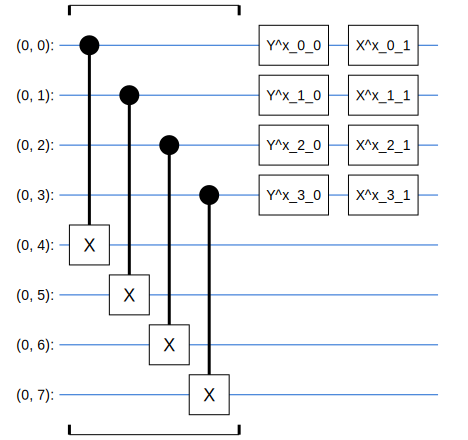

In [ ]:
qubits = cirq.GridQubit.rect(1,8)
SVGCircuit(variational_swap_test_circuit(qubits[:4],qubits[4:8],np.reshape(sp.symbols('x_:4_:'+str(2)),(-1,2)))[0])
# print(variational_swap_test_circuit(qubits[:4],qubits[4:8],np.reshape(sp.symbols('x_:4_:'+str(2)),(-1,2)))[1])

In [ ]:
def data_encoding_circuit(qubits,rotations):
  
  circuit =  cirq.Circuit()
  for i,q in enumerate(qubits):
    circuit += cirq.ry(rotations[i])(q)
  return circuit,rotations

In [ ]:
class SwapTestLayer(tf.keras.layers.Layer):
  def __init__(self,d_encoding_circuit,g_encoding_circuit,swap_test_circuit,swap_test_symbol_values,operators,use_sampled=False,name='Swap_Test_Layer'):
    super(SwapTestLayer,self).__init__(name=name)
    self.data_encoding_circuit_ = data_encoding_circuit
    self.data_encoding_circuit,self.real_input_symbols = d_encoding_circuit
    self.gen_encoding_circuit,self.gen_input_symbols = g_encoding_circuit
    self.fidelity_circuit,self.param_symbols = swap_test_circuit
    self.param_symbols_values = swap_test_symbol_values
    self.operators = operators
    self.use_sampled = use_sampled
    self.main_name = name
   
  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'name':self.main_name,
        'param_symbol_names':np.reshape(self.param_symbols,(-1,2))
    })
    return config
  
  def build(self,input_shape):
    self.parameters = tf.Variable(self.param_symbols_values,
                                  trainable=True,
                                  dtype = tf.dtypes.float32)
    self.full_circuit = tfq.layers.AddCircuit()(self.data_encoding_circuit,append=self.fidelity_circuit)
    self.full_circuit = tfq.layers.AddCircuit()(self.gen_encoding_circuit,append=self.full_circuit)
    self.symbol_names = tfq.util.get_circuit_symbols(tfq.from_tensor(self.full_circuit)[0])
    
  def call(self,inputs):
    real_data_inputs = inputs[0]
    generated_data_inputs = inputs[1]
    batch_size = tf.shape(real_data_inputs)[0]
    full_circuit_batch = tf.repeat(self.full_circuit,repeats=batch_size,name=self.main_name+'-tiled_fidelity_circuits') 
    tiled_parameters = tf.tile(tf.expand_dims(self.parameters,0),multiples=[batch_size,1])
    joined_parameters = tf.concat([real_data_inputs,generated_data_inputs],axis=-1)
    joined_parameters = tf.concat([joined_parameters,tiled_parameters],axis=-1)
    # q_overlap = tf.function(quantum_overlap)
    # overlap = quantum_overlap(self.data_encoding_circuit_,tf.reduce_mean(real_data_inputs,axis=0),tf.reduce_mean(generated_data_inputs,axis=0))
    if not self.use_sampled:
      return tfq.layers.Expectation()(full_circuit_batch,
                                      symbol_names=self.symbol_names,
                                      operators=self.operators,
                                      symbol_values=joined_parameters)  #,overlap
    else:
      return tfq.layers.SampledExpectation()(full_circuit_batch,
                                      symbol_names=self.symbol_names,
                                      operators=self.operators,
                                      symbol_values=joined_parameters,
                                      repetitions=1000)                #,overlap

In [ ]:
def create_discriminator(real_data_inputs,gen_data_inputs,layers,filters,filter_size,stride,fidelity_test_params,optimizer,use_sampled=False,backend=None,name='Discriminator'):
  d_qubits = cirq.GridQubit.rect(1,8)
  data_qubits = d_qubits[:4]
  generator_qubits = d_qubits[4:]
  # normalized_conv_output_gen = tf.keras.Input(shape=(len(generator_qubits),),dtype=tf.dtypes.float32)    #generated data
  input_symbols = sp.symbols('i_:'+str(len(d_qubits)))
  swap_test_symbols = sp.symbols('x_:'+str(len(d_qubits)/2)+'_:'+str(2))
  normalized_conv_output_gen = generate_data_improved(gen_data_inputs,layers=layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='gen')
  normalized_conv_output_real = generate_data_improved(real_data_inputs,layers=layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='real')
  fidelity_test = SwapTestLayer(
                                d_encoding_circuit=data_encoding_circuit(qubits=data_qubits,rotations=input_symbols[:len(data_qubits)]),
                                g_encoding_circuit=data_encoding_circuit(qubits=generator_qubits,rotations=input_symbols[len(generator_qubits):]),
                                swap_test_circuit=variational_swap_test_circuit(qubits_a=data_qubits,qubits_b=generator_qubits,rotations=swap_test_symbols),
                                swap_test_symbol_values=fidelity_test_params,
                                operators=swap_test_op(data_qubits,generator_qubits) )
  expectation_gen = fidelity_test([normalized_conv_output_real,normalized_conv_output_gen])   #,gen_overlap
  # expectation_real = fidelity_test(normalized_conv_output_real,normalized_conv_output_real)  #,real_overlap
  expectation_gen = tf.add(expectation_gen,tf.constant(0.000001)) #regularization
  log_disc_dist = tf.math.log(tf.keras.backend.flatten(expectation_gen))
  # log_real_dist = tf.math.log(tf.keras.backend.flatten(expectation_real))
  final_output = -log_disc_dist

  discriminator_model = tf.keras.Model(inputs=[real_data_inputs,gen_data_inputs],outputs=[final_output],name=name)    #expectation_gen,expectation_real,
  disc_optimizer = optimizer(learning_rate=0.0001)  
  disc_loss = lambda x,y: -tf.reduce_mean(y)
  discriminator_model.compile(optimizer=disc_optimizer,loss=disc_loss)  #,loss_weights=[0,0,1]

  return discriminator_model      #,normalized_conv_output_gen,normalized_conv_output_real

In [ ]:
real_data_inputs = tf.keras.Input(shape=(X_e_0.shape[1], X_e_0.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_real')
gen_data_inputs = tf.keras.Input(shape=(X_e_0.shape[1], X_e_0.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_generated')
# disc_layers = 2
# disc_filter_size = [4,3,2]
# disc_stride = [1,1,1]
#######    #for improved
disc_layers = [2,2]
disc_filters = [1,1]
disc_filter_shape = [(3,3),(2,2)]  
disc_stride = [(2,2),(2,2)]
#######
discriminator_model = create_discriminator(                        #,gen_data,real_data 
    real_data_inputs=real_data_inputs,
    gen_data_inputs=gen_data_inputs,
    layers=disc_layers,
    filters=disc_filters,
    filter_size=disc_filter_shape,
    stride=disc_stride,
    fidelity_test_params= np.ndarray.flatten(np.array([0.5 , 1.0] * 4)),
    optimizer=tf.keras.optimizers.Adam,
    use_sampled=False,
    backend=None,name='Discriminator_Model')

In [ ]:
np.ndarray.flatten(np.array([0.5 , 1.0] * 4)).shape

(8,)

In [ ]:
discriminator_model.summary()

Model: "Discriminator_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer_real (InputLayer)  [(None, 8, 8)]       0           []                               
                                                                                                  
 Input_layer_generated (InputLa  [(None, 8, 8)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Quantum_Convolutional_Layer_wi  (None, 4, 4, 1)     864         ['Input_layer_real[0][0]']       
 th_padding1real (QConv2D_layer                                                                   
 )                                                                              

In [ ]:
def create_generator(real_data_inputs,gen_data_inputs,layers,filters,filter_size,stride,fidelity_test_params,optimizer,use_sampled=False,backend=None,name='Generator'):
  g_qubits = cirq.GridQubit.rect(1,8)
  data_qubits = g_qubits[:4]
  generator_qubits = g_qubits[4:]
  normalized_conv_output_real = tf.keras.Input(shape=(len(generator_qubits),),dtype=tf.dtypes.float32) 
  input_symbols = sp.symbols('i_:'+str(len(g_qubits)))
  swap_test_symbols = sp.symbols('x_:'+str(len(g_qubits)/2)+'_:'+str(2))
  normalized_conv_output_gen = generate_data_improved(gen_data_inputs,layers=layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='gen')
  normalized_conv_output_real = generate_data_improved(real_data_inputs,layers=layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='real')
  fidelity_test = SwapTestLayer(
                                d_encoding_circuit=data_encoding_circuit(qubits=data_qubits,rotations=input_symbols[:len(data_qubits)]),
                                g_encoding_circuit=data_encoding_circuit(qubits=generator_qubits,rotations=input_symbols[len(generator_qubits):]),
                                swap_test_circuit=variational_swap_test_circuit(qubits_a=data_qubits,qubits_b=generator_qubits,rotations=swap_test_symbols),
                                swap_test_symbol_values=fidelity_test_params,
                                operators=swap_test_op(data_qubits,generator_qubits) )
  expectation_gen = fidelity_test([normalized_conv_output_real,normalized_conv_output_gen])
  expectation_gen = tf.add(expectation_gen,tf.constant(0.000001))
  log_gen_dist = tf.math.log(tf.keras.backend.flatten(expectation_gen))
  generator_model = tf.keras.Model(inputs=[real_data_inputs,gen_data_inputs],outputs=[expectation_gen,log_gen_dist],name=name)
  gen_optimizer = optimizer(learning_rate=0.0001)  
  gen_loss = lambda x,y: tf.reduce_mean(y)
  generator_model.compile(optimizer=gen_optimizer,loss=gen_loss,loss_weights=[0,1])

  return generator_model

In [ ]:
real_data_inputs = tf.keras.Input(shape=(X_e_0.shape[1], X_e_0.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_real')
gen_data_inputs = tf.keras.Input(shape=(X_e_0.shape[1], X_e_0.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_generated')
# gen_layers = 2
# gen_filter_size = [4,3,2]
# gen_stride = [1,1,1]
######
gen_layers = [2,2]
gen_filters = [1,1]
gen_filter_shape = [(3,3),(2,2)]  
gen_stride = [(2,2),(2,2)]
######
generator_model = create_generator(
    real_data_inputs=real_data_inputs,
    gen_data_inputs=gen_data_inputs,
    layers=gen_layers,
    filters=gen_filters,
    filter_size=gen_filter_shape,
    stride=gen_stride,
    fidelity_test_params= np.ndarray.flatten(np.array([0.5 , 1.0] * 4)),
    optimizer=tf.keras.optimizers.Adam,
    use_sampled=False,
    backend=None,name='Generator_Model')

In [ ]:
generator_model.summary()

Model: "Generator_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer_real (InputLayer)  [(None, 8, 8)]       0           []                               
                                                                                                  
 Input_layer_generated (InputLa  [(None, 8, 8)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Quantum_Convolutional_Layer_wi  (None, 4, 4, 1)     864         ['Input_layer_real[0][0]']       
 th_padding1real (QConv2D_layer                                                                   
 )                                                                                  

In [ ]:
# generator_model.trainable_variables
generator_model.get_layer('Swap_Test_Layer').input
# generator_model.get_input_at('Batch_Normalization_real')

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'Intermediate_output_layer_real')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'Intermediate_output_layer_gen')>]

In [ ]:
def quantum_state_overlap(generator_model_,real_data,random_data):
  # intermediate_output_gen = generator_model_.get_layer('Intermediate_output_layer_gen').output
  intermediate_output_gen = generator_model_.get_layer('Swap_Test_Layer').input[1]
  # intermediate_output_real = generator_model_.get_layer('Intermediate_output_layer_real').output
  intermediate_output_real = generator_model_.get_layer('Swap_Test_Layer').input[0]
  generator_model_1 = tf.keras.models.Model(inputs=[generator_model_.input],outputs=[intermediate_output_real,intermediate_output_gen])
  random_data_samples = generator_model_1.predict([real_data,random_data])
  rotations_r = sp.symbols('real_x_:'+str(intermediate_output_real.shape[1]))
  rotations_g = sp.symbols('gen_x_:'+str(intermediate_output_gen.shape[1]))
  circuit1 =  cirq.Circuit()
  circuit2 = cirq.Circuit()
  qubits1 = cirq.GridQubit.rect(1,4)
  qubits2 = cirq.GridQubit.rect(1,4)
  for i,q in enumerate(qubits1):
    circuit1 += cirq.ry(rotations_r[i])(q)
  for i,q in enumerate(qubits2):
    circuit2 += cirq.ry(rotations_g[i])(q)
  # real_state = tfq.layers.State()(circuit1,symbol_names=rotations_r,symbol_values=tf.reshape(tf.reduce_mean(random_data_samples[0],axis=0),(1,random_data_samples[0].shape[1])))
  real_state = tfq.layers.State()(circuit1,symbol_names=rotations_r,symbol_values=np.mean(random_data_samples[0],axis=0).reshape(1,len(random_data_samples[0][0])))
  real_state = real_state.to_tensor(default_value=0).numpy()
  # gen_state = tfq.layers.State()(circuit2,symbol_names=rotations_g,symbol_values=tf.reshape(tf.reduce_mean(random_data_samples[1],axis=0),(1,random_data_samples[1].shape[1])))
  gen_state = tfq.layers.State()(circuit2,symbol_names=rotations_g,symbol_values=np.mean(random_data_samples[1],axis=0).reshape(1,len(random_data_samples[0][0])))
  gen_state = gen_state.to_tensor(default_value=0).numpy()
  # gen_state = tf.reshape(gen_state.to_tensor(default_value=0),(random_data_samples[1].shape[1],1))
  # state_overlap = tf.tensordot(real_state,gen_state,1)
  state_overlap = np.dot(real_state[0],gen_state[0])
  return state_overlap

In [ ]:
r = tf.ragged.constant([[1,2,3,4]])
r.shape
print(r.to_tensor(default_value=0))

tf.Tensor([[1 2 3 4]], shape=(1, 4), dtype=int32)


In [ ]:
class EntangledQGAN():
  def __init__(self, filters,filter_size,stride,layers,
               generator_model, discriminator_model, fidelity_test_params=None,
               use_sampled=False,backend=None,name='QGAN_Model'):
    self.layers = layers
    self.filters = filters
    self.filter_size = filter_size
    self.stride = stride
    self.d_loss = []
    self.g_loss = []
    self.param_history = []
    self.state_overlap_l = []
    self.generator_model = generator_model
    self.discriminator_model = discriminator_model
    self.use_sampled = use_sampled
  
  def train(self,real_data_inputs, generator_data_inputs, batch_size, g_epochs, d_epochs, n_episodes):
    real_data = tf.keras.Input(shape=(real_data_inputs.shape[1], real_data_inputs.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_real')
    gen_data = tf.keras.Input(shape=(generator_data_inputs.shape[1], generator_data_inputs.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_generated')
    for episode in range(n_episodes):
      self.param_history.append(discriminator_model.get_layer('Swap_Test_Layer').get_weights())
      d_history = discriminator_model.fit(x=[real_data_inputs,gen_data_inputs],
                                          y=[tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32),
                                             tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32),
                                             tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32)],
                                             epochs=d_epochs,batch_size=batch_size,verbose=0)
      self.d_loss.append(d_history.history['loss'])
      updated_fidelity_test_params = np.array(discriminator_model.get_layer('Swap_Test_Layer').get_weights())
      self.generator_model.get_layer('Swap_Test_Layer').set_weights(np.reshape(updated_fidelity_test_params,(-1,8)))

      g_history = generator_model.fit(x=[real_data_inputs,gen_data_inputs],
                                      y=[tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32),
                                        tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32)],
                                        epochs=g_epochs,batch_size=batch_size,verbose=0)
      self.g_loss.append(g_history.history['loss'])

      state_overlap = quantum_state_overlap(self.generator_model,real_data_inputs,generator_data_inputs)
      self.state_overlap_l += [state_overlap]
      print(f'Step = {episode}:')
      print(f'discriminator_loss={self.d_loss[-1]}')
      print(f'generator_loss={self.g_loss[-1]}')
      print(f'overlap={self.state_overlap}')
      print('-'*50) 

    return self.g_loss,self.d_loss,self.param_history,self.state_overlap_l   

  def create_images(self,generator_model_,real_data,random_data):
    intermediate_output = self.generator_model.get_layer('Quantum_Convolutional_Layer_with_padding2gen').output
    generator_model_1 = tf.keras.models.Model(inputs=[self.generator_model_.input],outputs=[intermediate_output])
    print("Generating samples")
    samples = generator_model_1.predict([real_data,random_data])
    print("Applying PCA to real data")
    flattened_real_data = real_data.reshape(-1,real_data.shape[1]*real_data.shape[2])
    pca = PCA(n_components=4)
    pca.fit(X_flatten)
    print("Applying inverse PCA to generated samples")
    X_pca_inv_transform = pca.inverse_transform([tf.keras.backend.flatten(samples_) for samples_ in samples])
    X_pca_inv_transform = np.reshape(X_pca_inv_transform,real_data.shape)
    print("Generated Images:")
    fig = plt.figure(figsize=(26,18))
    gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
    for i in range(8):
      ax = plt.subplot(gs[i//4, 4 + i%4])
      plt.imshow(X_pca_inv_transform[i])

In [ ]:
def qgan_train(real_data_inputs,gen_data_inputs,filters,
               filter_size,stride,
               batch_size,g_epochs,d_epochs,n_episodes,layers,
               use_sampled=False,backend=None,name='QGAN_Model'):
  
  real_data = tf.keras.Input(shape=(real_data_inputs.shape[1], real_data_inputs.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_real')
  gen_data = tf.keras.Input(shape=(gen_data_inputs.shape[1], gen_data_inputs.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_generated')
  # fidelity_test_params = np.ndarray.flatten(np.array([[0.5 , 1.0]] * 4))
  # fidelity_test_params = np.array([0.0]*8)
  fidelity_test_params = tf.random.normal([8,])
  generator_model = create_generator(real_data_inputs=real_data,
                                     gen_data_inputs=gen_data,
                                     layers=layers,
                                     filters=filters,
                                     filter_size=filter_size,
                                     stride=stride,
                                     fidelity_test_params=fidelity_test_params ,
                                     optimizer=tf.keras.optimizers.Adam,
                                     use_sampled=False,
                                     backend=None,name='Generator_Model')
  
  discriminator_model = create_discriminator(real_data_inputs=real_data,
                                     gen_data_inputs=gen_data,
                                     layers=layers,
                                     filter_size=filter_size,
                                     filters=filters,
                                     stride=stride,
                                     fidelity_test_params=fidelity_test_params,
                                     optimizer=tf.keras.optimizers.Adam,
                                     use_sampled=False,
                                     backend=None,name='Discriminator_Model')
  d_loss = []
  g_loss = []
  param_history = []
  state_overlap_l = []  
  for episode in range(n_episodes):
    param_history.append(discriminator_model.get_layer('Swap_Test_Layer').get_weights())
    d_history = discriminator_model.fit(x=[real_data_inputs,gen_data_inputs],
                                        y=[tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32),
                                           tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32),
                                           tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32)],
                                        epochs=d_epochs,batch_size=batch_size,verbose=0)
    d_loss.append(d_history.history['loss'])
    updated_fidelity_test_params = np.array(discriminator_model.get_layer('Swap_Test_Layer').get_weights())
    generator_model.get_layer('Swap_Test_Layer').set_weights(np.reshape(updated_fidelity_test_params,(-1,8)))

    g_history = generator_model.fit(x=[real_data_inputs,gen_data_inputs],
                                    y=[tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32),
                                      tf.zeros_like(real_data_inputs,dtype=tf.dtypes.float32)],
                                    epochs=g_epochs,batch_size=batch_size,verbose=0)
    g_loss.append(g_history.history['loss'])

    state_overlap = quantum_state_overlap(generator_model,real_data_inputs,gen_data_inputs)
    state_overlap_l += [state_overlap]
    print(f'Step = {episode}:')
    print(f'discriminator_loss={d_loss[-1]}')
    print(f'generator_loss={g_loss[-1]}')
    print(f'overlap={state_overlap}')
    print('-'*50)

  return g_loss,d_loss,param_history,state_overlap_l  #,discriminator_model.get_output_at('Swap_Test_Layer').numpy(),generator_model.get_output_at('Swap_Test_Layer').numpy()

In [ ]:
z_shape = tf.shape(X_e_0)
z = tf.random.normal(z_shape)
print(tf.shape(z))

tf.Tensor([100   8   8], shape=(3,), dtype=int32)


In [ ]:
# filter_size = [4,3,2]
# stride = [1,1,1]
layers = [2,2]
filters = [1,1]
filter_size = [(3,3),(2,2)]  
stride = [(2,2),(2,2)]
batch_size = 20
g_epochs = 5
d_epochs = 1
n_episodes = 10

print('Model Training Initiated:')
gen_per,disc_per,param_history,state_overlap = qgan_train(X_e_0 , z ,filters=filters, layers=layers,
                                            filter_size = filter_size,stride = stride,batch_size = batch_size,
                                            g_epochs = g_epochs,d_epochs = d_epochs,n_episodes = n_episodes)

Model Training Initiated:
Step = 0:
discriminator_loss=[-0.32625746726989746]
generator_loss=[-0.5132628083229065, -0.5156253576278687, -0.5179876089096069, -0.5203539133071899, -0.5227224826812744]
overlap=(0.9349516034126282+0j)
--------------------------------------------------
Step = 1:
discriminator_loss=[-0.3283003270626068]
generator_loss=[-0.5183403491973877, -0.520693838596344, -0.5230486392974854, -0.5254048705101013, -0.5277643203735352]
overlap=(0.9381131529808044+0j)
--------------------------------------------------
Step = 2:
discriminator_loss=[-0.3303511440753937]
generator_loss=[-0.5233169794082642, -0.5256615877151489, -0.5280106067657471, -0.5303590297698975, -0.5327135324478149]
overlap=(0.9411754608154297+0j)
--------------------------------------------------
Step = 3:
discriminator_loss=[-0.33241331577301025]
generator_loss=[-0.528191328048706, -0.5305306911468506, -0.5328733921051025, -0.5352190136909485, -0.5375686883926392]
overlap=(0.9441469311714172+0j)
-----

In [ ]:
discriminator_model.non_trainable_variables

[<tf.Variable 'batch_normalization_2/moving_mean:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'batch_normalization_2/moving_variance:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'batch_normalization_1/moving_mean:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'batch_normalization_1/moving_variance:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'Swap_Test_Layer/Variable:0' shape=(8,) dtype=float32, numpy=array([0.5, 1. , 0.5, 1. , 0.5, 1. , 0.5, 1. ], dtype=float32)>]

In [ ]:
discriminator_model.outputs   #get_output_at('BatchNormalization')

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.math.add')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Swap_Test_Layer')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.negative')>]

In [ ]:
print(np.ndarray.flatten(np.array(gen_per)))
print(np.ndarray.flatten(np.array(disc_per)))
gen_per = np.ndarray.flatten(np.array(gen_per))
disc_per = np.ndarray.flatten(np.array(disc_per))

[-2.16324854 -2.16326189 -2.16328502 -2.16330576 -2.16332173 -2.16334033
 -2.16335821 -2.16336775 -2.16337657 -2.16338658 -2.16339922 -2.16340518
 -2.16340995 -2.16341519 -2.16342163 -2.16342688 -2.16343045 -2.16343212
 -2.16343546 -2.16343904 -2.16344213 -2.16344452 -2.16344523 -2.1634469
 -2.16344929 -2.16345096 -2.16345072 -2.16345215 -2.16345286 -2.16345549
 -2.16345644 -2.16345668 -2.16345692 -2.16345716 -2.16345811 -2.16345835
 -2.16346049 -2.1634593  -2.16346097 -2.16346073 -2.16346097 -2.16346121
 -2.16346216 -2.16346216 -2.16346216 -2.16346288 -2.16346359 -2.16346359
 -2.16346407 -2.16346407]
[-2.16022873 -2.16046166 -2.16075373 -2.16097641 -2.16117501 -2.16137671
 -2.1615665  -2.16173148 -2.16187215 -2.16200066 -2.16212249 -2.16223764
 -2.16234183 -2.16243029 -2.16250873 -2.16258097 -2.16264987 -2.162714
 -2.16276884 -2.16281915 -2.16286278 -2.16290402 -2.16294217 -2.16297793
 -2.16300917 -2.16303682 -2.16306162 -2.16308594 -2.16310835 -2.16312909
 -2.16314626 -2.16316342 -2.

In [ ]:
import matplotlib.gridspec as gridspec

def plot_loss(gen_loss,disc_loss,epochs):
  fig = plt.figure(figsize=(16,9))
  gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
  epochs = [i for i in range(epochs)]
  epoch = epochs[-1]
  # plot loss curve
  ax_loss = plt.subplot(gs[:,:4])
  ax_loss.set_xlim(0, 1.1*epoch)
  ax_loss.plot(epochs, np.mean(gen_loss,axis=1), label="Generator")
  ax_loss.plot(epochs, np.mean(disc_loss,axis=1), label="Discriminator")
  ax_loss.set_xlabel('Epoch', fontsize=20)
  ax_loss.set_ylabel('Loss', fontsize=20)
  ax_loss.grid(True)
  ax_loss.legend(fontsize=15)

In [ ]:
def plot_state_overlap(overlap,epochs):
  fig = plt.figure(figsize=(16,9))
  gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
  epochs = [i for i in range(epochs)]
  epoch = epochs[-1]
  ax_loss = plt.subplot(gs[:,:4])
  ax_loss.set_xlim(0, 1.1*epoch)
  ax_loss.plot(epochs, overlap, label="State Overlap")
  ax_loss.set_xlabel('Epoch', fontsize=20)
  ax_loss.set_ylabel('Overlap', fontsize=20)
  ax_loss.grid(True)
  ax_loss.legend(fontsize=15)

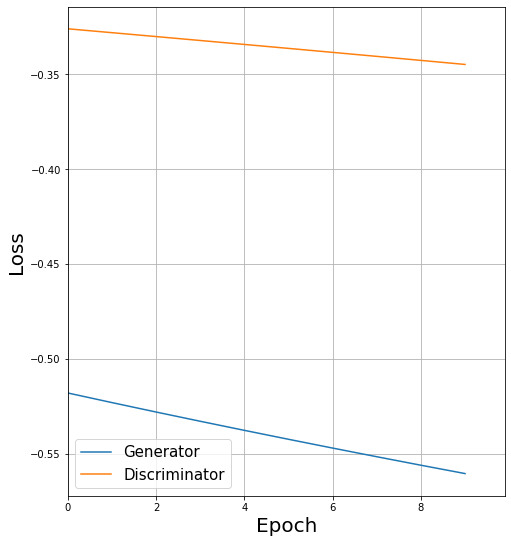

In [ ]:
plot_loss(gen_loss=gen_per,disc_loss=disc_per,epochs=n_episodes)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


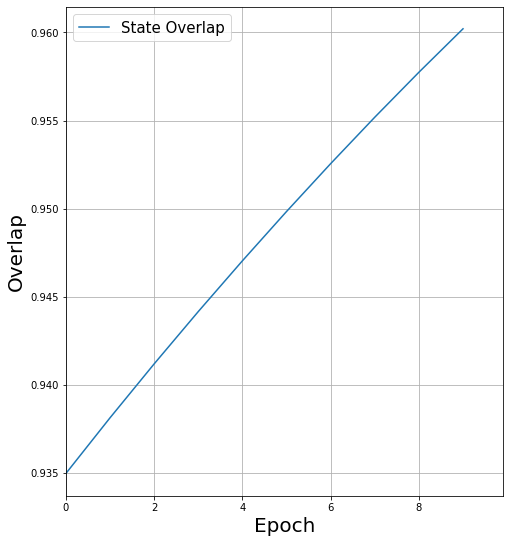

In [ ]:
plot_state_overlap(state_overlap,epochs=n_episodes)

In [ ]:
def create_images(generator_model_,real_data,random_data):
  intermediate_output = generator_model_.get_layer('Swap_Test_Layer').input[1]
 
  generator_model_1 = tf.keras.models.Model(inputs=[generator_model_.input],outputs=[intermediate_output])
 
  random_data_samples = generator_model_1.predict([real_data,random_data])
 
  return random_data_samples

In [ ]:
samples = create_images(generator_model,X_e_0,z)

In [ ]:
print(samples)

(0.9027532+0j)


In [ ]:
from sklearn.decomposition import PCA
X_flatten = X_e_0.reshape(-1,X_e_0.shape[1]*X_e_0.shape[2])
pca = PCA(n_components=4)
pca.fit(X_flatten)

PCA(n_components=4)

In [ ]:
samples.shape

In [ ]:
X_pca_inv_transform = pca.inverse_transform([tf.keras.backend.flatten(samples_) for samples_ in samples])

In [ ]:
X_pca_inv_transform = np.reshape(X_pca_inv_transform,X_e_0.shape)
print(X_pca_inv_transform.shape)

(100, 8, 8)


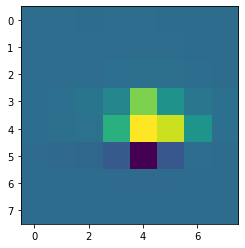

In [ ]:
plt.imshow(X_pca_inv_transform[6,:,:])

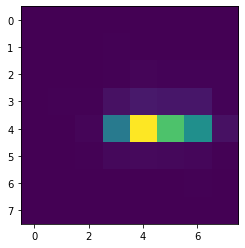

In [ ]:
plt.imshow(X_e_0[6,:,:])

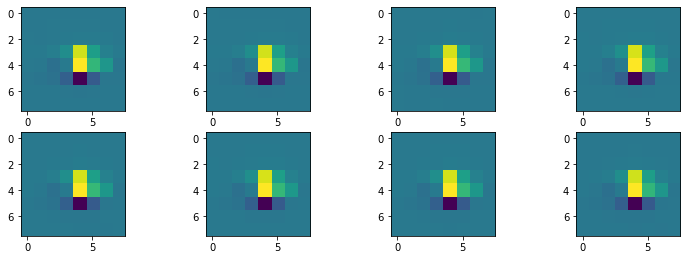

In [ ]:
fig = plt.figure(figsize=(26,18))
gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
for i in range(8):
  ax = plt.subplot(gs[i//4, 4 + i%4])
  plt.imshow(X_pca_inv_transform[i])

In [ ]:
def FID(model,images_1,images_2):
  images_1 = preprocess_input(images_1)
  images_2 = preprocess_input(images_2)
  
  act1 = model.predict(images_1)
  act2 = model.predict(images_2)
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  ssdiff = np.sum((mu1-mu2)**2)
  covmean = sqrtm(sigma1.dot(sigma2))
  if iscomplexobj(covmean):
    covmean =covmean.real
  
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0*covmean)
  return fid

In [ ]:
def scale_images(images,size):
  images_list = []
  for image in images:
    new_image = resize(image,size,0)
    images_list.append(new_image)
  return asarray(images_list)

In [ ]:
inc_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [ ]:
new_images_e = scale_images(X_e_0[:1000],(299,299,3))
new_images_inv = scale_images(X_pca_inv_transform[:1000],(299,299,3))
new_images_z = scale_images(z[:1000],(299,299,3))
FID(inc_model,new_images_e,new_images_inv)